# Offside

## Introduction, Reference Domain, and Objectives
The Offside project starts from the need of creating a recommendation system based on machine learning which, given a football player, returns a series of players as similar as possible based on a set of technical-tactical data. The reference domain is, obviously, the world of football, and the reference platform for data retrieval is Fbref, a consultation source that includes data relating to players, teams and championships in an easily to consult, -and scrape-, fashion.

The approach that the project intends to adopt is based on a rather simple notion: let's assume we have a two-dimensional Cartesian plane, where each point corresponds to a player based on a pair of technical characteristics of our choice. The players most similar to the original player will be those who have the smallest distance on the Cartesian plane. It is sufficient to raise the plane to n dimensions, one for each of the technical attributes considered, to evaluate the similarity of the players on the hyperplane. The only caveat is that calculating the distance on a n-dimensional plane requires a little bit more effort than doing the same thing for a bi-dimensional plane, but thanks to the use of the Euclidean distance, the problem will be solved quite easily. In the code block that follows, we will begin by importing all the necessary libraries for the model.

In [183]:
# Import necessary libraries
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

## Data Retrieval, Parsing, Preparation, Cleaning, and Optimization
This section aims to retrieve data from multiple web URLs, each pointing to a webpage on FBref, a website providing comprehensive football statistics and tables. The `leagues_urls` dictionary contains URLs for different football leagues, and the code iterates through this dictionary to scrape data for each league.

The `pd.read_html()` function is utilized to parse the HTML content of the webpages and extract tables. Before parsing, the `.replace()` method is employed to remove HTML comment tags ('<!--' and '-->') from the webpage content. This ensures that the HTML can be imported correctly and without hidden elements ruining the formatting, allowing `read_html()` to parse it effectively. This workaround was sourced from a StackOverflow discussion (https://stackoverflow.com/questions/77548912/how-to-extract-table-from-a-webpage-using-its-id).

For each league, the `pd.read_html()` function call fetches the HTML content using `requests.get(url).text`, which is then passed to `read_html()` for parsing. The `attrs` parameter specifies the HTML attribute `id` of the table element to be extracted, which is 'stats_standard', a table containing player attributes. The `[0]` index is used to select the first table matching the specified attributes.

After scraping the data, we prepare it for further analysis and processing. Column names are redefined to enhance clarity and comprehension of the dataset. These new column names categorize various aspects of player information, performance metrics, and expected outcomes. Following the renaming process, the data types of specific columns are adjusted for consistency and suitability for analysis. String columns are converted to the string data type, while categorical columns are converted to the categorical data type for efficient storage and computation. Additionally, numerical data columns are converted to numeric types, with appropriate error handling for inconsistencies or invalid entries. Given that the model will be based on the computation of n-Dimensional Euclidean Distance (with n being the number of attributes considered), having accurate numerical values is crucial for precision and consistency.

Unnecessary information is removed from the dataset to streamline its structure and optimize analytical processes. Columns such as alphabetical rank and nationality are deemed irrelevant for the intended analysis and thus removed. Similarly, redundant columns are eliminated, including the age attribute (since the year of birth is already provided) and a redundant hyperlink column (the last column, which is a hyperlink provided by FBref). The processed dataset is then exported to a CSV file named `"players.csv"` to facilitate future analysis and sharing. Below is a description of the dataset columns as provided by the website.

### Dataset Columns Explanation

#### Background Information
1. **(Background Information, Full Name)**: indicates the full name of the player
2. **(Background Information, Position)**: specifies the primary position of the player
3. **(Background Information, Squad)**: denotes the squad the player belongs to
4. **(Background Information, Year of Birth)**: indicates the year of birth of the player
5. **(Background Information, League)**: denotes the league the player is associated with

#### Playing Time
6. **(Playing Time, MP)**: stands for Matches Played
7. **(Playing Time, Starts)**: denotes the number of matches started by the player
8. **(Playing Time, Min)**: represents the total minutes played by the player
9. **(Playing Time, 90s)**: indicates the total minutes played divided by 90

#### Performance
10. **(Performance, Gls)**: represents the number of goals scored by the player
11. **(Performance, Ast)**: denotes the number of assists made by the player
12. **(Performance, G+A)**: indicates the total number of goals and assists combined
13. **(Performance, G-PK)**: represents the number of goals scored excluding penalty kicks
14. **(Performance, PK)**: denotes the number of penalty kicks scored by the player
15. **(Performance, PKatt)**: represents the number of penalty kicks attempted by the player
16. **(Performance, CrdY)**: indicates the number of yellow cards received by the player
17. **(Performance, CrdR)**: denotes the number of red cards received by the player

#### Expected
18. **(Expected, xG)**: represents the expected goals for the player
19. **(Expected, npxG)**: denotes the non-penalty expected goals for the player
20. **(Expected, xAG)**: represents the expected assists for the player
21. **(Expected, npxG+xAG)**: indicates the sum of non-penalty expected goals and expected assists

#### Progression
22. **(Progression, PrgC)**: stands for progressive carries made by the player
23. **(Progression, PrgP)**: denotes progressive passes made by the player
24. **(Progression, PrgR)**: represents progressive carries made by the player

#### Per 90 Minutes
25. **(Per 90 Minutes, Gls)**: represents the average number of goals scored per 90 minutes
26. **(Per 90 Minutes, Ast)**: denotes the average number of assists made per 90 minutes
27. **(Per 90 Minutes, G+A)**: indicates the average number of goals and assists combined per 90 minutes
28. **(Per 90 Minutes, G-PK)**: represents the average number of goals scored excluding penalty kicks per 90 minutes
29. **(Per 90 Minutes, G+A-PK)**: denotes the average number of goals and assists combined excluding penalty kicks per 90 minutes
30. **(Per 90 Minutes, xG)**: represents the average expected goals per 90 minutes
31. **(Per 90 Minutes, xAG)**: denotes the average expected assists per 90 minutes
32. **(Per 90 Minutes, xG+xAG)**: indicates the average sum of expected goals and expected assists per 90 minutes
33. **(Per 90 Minutes, npxG)**: represents the average non-penalty expected goals per 90 minutes
34. **(Per 90 Minutes, npxG+xAG)**: denotes the average sum of non-penalty expected goals and expected assists per 90 minutes

These columns collectively provide a comprehensive overview of player performance, background, and progression metrics, facilitating in-depth analysis and insights as the further progression of the model will demonstrate.

In [184]:
# Dictionary of league URLs
leagues_urls = {
    "Serie A": 'https://fbref.com/en/comps/11/stats/Serie-A-Stats',
    "Premier League": 'https://fbref.com/en/comps/9/stats/Premier-League-Stats',
    "Bundesliga": 'https://fbref.com/en/comps/20/stats/Bundesliga-Stats',
    "La Liga": 'https://fbref.com/en/comps/12/stats/La-Liga-Stats',
    "Ligue 1": 'https://fbref.com/en/comps/13/stats/Ligue-1-Stats',
    "Eredivisie": 'https://fbref.com/en/comps/23/stats/Eredivisie-Stats'
}

# Set your desired league filter
league_filter = ["Serie A", 
                 "Premier League", 
                 "Bundesliga", 
                 "La Liga", 
                 "Ligue 1", 
                 "Eredivisie"
                 ]

# Initialization of an empty list to hold DataFrames
dfs = []

# Iteration through the league URLs dictionary
for league, url in leagues_urls.items(): 
    if 'league_filter' in locals() and league not in league_filter:
        continue  # Skip if the league is not in the league_filter list
    # Utilize the pandas library to read the HTML content from the specified URL
    # Replace HTML comments to ensure proper parsing of the content
    # Extract the data table with specified attributes
    df = pd.read_html(
        requests.get(url).text.replace('<!--','').replace('-->','')
        ,attrs={'id':'stats_standard'}
    )[0]

    # Definition of new column names to be used for the DataFrame
    new_columns = [
        "(Background Information, Alphabetical Rank)",
        "(Background Information, Full Name)",
        "(Background Information, Nation)",
        "(Background Information, Position)",
        "(Background Information, Squad)",
        "(Background Information, Age)",
        "(Background Information, Year of Birth)",
        "(Playing Time, MP)",
        "(Playing Time, Starts)",
        "(Playing Time, Min)",
        "(Playing Time, 90s)",
        "(Performance, Gls)",
        "(Performance, Ast)",
        "(Performance, G+A)",
        "(Performance, G-PK)",
        "(Performance, PK)",
        "(Performance, PKatt)",
        "(Performance, CrdY)",
        "(Performance, CrdR)",
        "(Expected, xG)",
        "(Expected, npxG)",
        "(Expected, xAG)",
        "(Expected, npxG+xAG)",
        "(Progression, PrgC)",
        "(Progression, PrgP)",
        "(Progression, PrgR)",
        "(Per 90 Minutes, Gls)",
        "(Per 90 Minutes, Ast)",
        "(Per 90 Minutes, G+A)",
        "(Per 90 Minutes, G-PK)",
        "(Per 90 Minutes, G+A-PK)",
        "(Per 90 Minutes, xG)",
        "(Per 90 Minutes, xAG)",
        "(Per 90 Minutes, xG+xAG)",
        "(Per 90 Minutes, npxG)",
        "(Per 90 Minutes, npxG+xAG)"
    ] + list(df.columns[36:])  

    # Assign the new column names to the DataFrame
    df.columns = new_columns

    # Conversion of specific columns to appropriate data types
    df["(Background Information, Full Name)"] = df["(Background Information, Full Name)"].astype("string")
    df["(Background Information, Position)"] = df["(Background Information, Position)"].astype("category")
    df["(Background Information, Squad)"] = df["(Background Information, Squad)"].astype("category")

    # List of numerical columns to convert to numeric data type
    numerical_columns_to_convert = [
        "(Background Information, Year of Birth)",
        "(Playing Time, MP)",
        "(Playing Time, Starts)",
        "(Playing Time, Min)",
        "(Playing Time, 90s)",
        "(Performance, Gls)",
        "(Performance, Ast)",
        "(Performance, G+A)",
        "(Performance, G-PK)",
        "(Performance, PK)",
        "(Performance, PKatt)",
        "(Performance, CrdY)",
        "(Performance, CrdR)",
        "(Expected, xG)",
        "(Expected, npxG)",
        "(Expected, xAG)",
        "(Expected, npxG+xAG)",
        "(Progression, PrgC)",
        "(Progression, PrgP)",
        "(Progression, PrgR)",
        "(Per 90 Minutes, Gls)",
        "(Per 90 Minutes, Ast)",
        "(Per 90 Minutes, G+A)",
        "(Per 90 Minutes, G-PK)",
        "(Per 90 Minutes, G+A-PK)",
        "(Per 90 Minutes, xG)",
        "(Per 90 Minutes, xAG)",
        "(Per 90 Minutes, xG+xAG)",
        "(Per 90 Minutes, npxG)",
        "(Per 90 Minutes, npxG+xAG)"
    ]

    # Conversion of specified columns to numeric data type
    for col in numerical_columns_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Removal of unnecessary columns from the DataFrame
    df.drop('(Background Information, Alphabetical Rank)', axis=1, inplace=True)
    df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

    # Addition of the league column to the DataFrame
    df["(Background Information, League)"] = league

    # Append the DataFrame to the initial DataFrame list
    dfs.append(df)

# Concatenation of DataFrames obtained from all leagues
df = pd.concat(dfs, ignore_index=True)

# Remove rows with missing values
df.dropna(inplace=True)

# Export the processed DataFrame to a CSV file
df.to_csv("Exports/Tables/players.csv", encoding='utf-8', index=False)

# Return the modified DataFrame
df

,"(Background Information, Full Name)","(Background Information, Nation)","(Background Information, Position)","(Background Information, Squad)","(Background Information, Age)","(Background Information, Year of Birth)","(Playing Time, MP)","(Playing Time, Starts)","(Playing Time, Min)","(Playing Time, 90s)",...,"(Per 90 Minutes, Ast)","(Per 90 Minutes, G+A)","(Per 90 Minutes, G-PK)","(Per 90 Minutes, G+A-PK)","(Per 90 Minutes, xG)","(Per 90 Minutes, xAG)","(Per 90 Minutes, xG+xAG)","(Per 90 Minutes, npxG)","(Per 90 Minutes, npxG+xAG)","(Background Information, League)"
0,Tammy Abraham,eng ENG,FW,Roma,25,1997.0,8.0,2.0,242.0,2.7,...,0.00,0.37,0.37,0.37,0.22,0.05,0.27,0.22,0.27,Serie A
1,Francesco Acerbi,it ITA,DF,Inter,35,1988.0,29.0,26.0,2388.0,26.5,...,0.04,0.15,0.11,0.15,0.06,0.07,0.13,0.06,0.13,Serie A
2,Yacine Adli,fr FRA,MF,Milan,23,2000.0,24.0,17.0,1407.0,15.6,...,0.13,0.19,0.06,0.19,0.02,0.14,0.16,0.02,0.16,Serie A
3,Michel Aebischer,ch SUI,MF,Bologna,26,1997.0,36.0,26.0,2230.0,24.8,...,0.04,0.04,0.00,0.04,0.04,0.06,0.11,0.04,0.11,Serie A
4,Lucien Agoume,fr FRA,MF,Inter,21,2002.0,1.0,0.0,5.0,0.1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Serie A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,Lequincio Zeefuik,nl NED,"MF,FW",AZ Alkmaar,18,2004.0,6.0,0.0,59.0,0.7,...,1.53,1.53,0.00,1.53,0.25,0.51,0.76,0.25,0.76,Eredivisie
3506,Lequincio Zeefuik,nl NED,"FW,MF",Volendam,18,2004.0,16.0,8.0,773.0,8.6,...,0.12,0.47,0.35,0.47,0.23,0.11,0.33,0.23,0.33,Eredivisie
3507,Ramiz Zerrouki,dz ALG,MF,Feyenoord,25,1998.0,26.0,15.0,1387.0,15.4,...,0.00,0.00,0.00,0.00,0.02,0.12,0.14,0.02,0.14,Eredivisie
3508,Giovanni van Zwam,nl NED,DF,Vitesse,19,2004.0,12.0,3.0,492.0,5.5,...,0.00,0.00,0.00,0.00,0.05,0.01,0.05,0.05,0.05,Eredivisie


In [187]:
import pandas as pd
import os

# Loading the players' dataframe
df = pd.read_csv("Exports/Tables/players.csv")

def calculate_player_rating(row):
    """
    Function to calculate a player's rating based on seasonal performances with weighted contributions
    and role-specific adjustments.
    """
    # Define weights for each statistic
    weights = {
        "(Performance, Gls)": 3,
        "(Performance, Ast)": 3,
        "(Performance, G+A)": 3.2,
        "(Performance, G-PK)": 2.5,
        "(Performance, PK)": -1,
        "(Performance, CrdY)": -1,
        "(Performance, CrdR)": -3,
        "(Expected, xG)": 2.5,
        "(Expected, npxG)": 2.5,
        "(Expected, xAG)": 2,
        "(Expected, npxG+xAG)": 2.2,
        "(Progression, PrgC)": 1.5,
        "(Progression, PrgP)": 1.5,
        "(Progression, PrgR)": 1.5,
        "(Playing Time, MP)": 1,
        "(Playing Time, Starts)": 1.2,
        "(Playing Time, Min)": 1.3,
        "(Playing Time, 90s)": 1.4,
        "(Per 90 Minutes, Gls)": 3,
        "(Per 90 Minutes, Ast)": 3,
        "(Per 90 Minutes, G+A)": 3.2,
        "(Per 90 Minutes, G-PK)": 2.5,
        "(Per 90 Minutes, G+A-PK)": 2.8,
        "(Per 90 Minutes, xG)": 2.5,
        "(Per 90 Minutes, xAG)": 2,
        "(Per 90 Minutes, xG+xAG)": 2.2,
        "(Per 90 Minutes, npxG)": 2.5,
        "(Per 90 Minutes, npxG+xAG)": 2.3,
    }
    
    # Adjustments for role-specific weights
    role_adjustments = {
        "GK": {
            "(Performance, Gls)": 4,
            "(Performance, Ast)": 4,
            "(Performance, G+A)": 4,
            "(Performance, G-PK)": 4,
            "(Performance, PK)": -3,
            "(Performance, PKatt)": -3,
            "(Performance, CrdY)": -1,
            "(Performance, CrdR)": -3,
            "(Expected, xG)": -3,
            "(Expected, npxG)": -3,
            "(Expected, xAG)": -2,
            "(Expected, npxG+xAG)": -2,
            "(Progression, PrgC)": 1,
            "(Progression, PrgP)": 1,
            "(Progression, PrgR)": 1,
            "(Playing Time, MP)": 1.7,
            "(Playing Time, Starts)": 1.8,
            "(Playing Time, Min)": 1.8,
            "(Playing Time, 90s)": 1.9,
        },
        "DF": {
            "(Expected, xG)": 1.2,
            "(Expected, npxG)": 1.2,
            "(Expected, xAG)": 1,
            "(Expected, npxG+xAG)": 1.1,
            "(Progression, PrgC)": 1.5,
            "(Progression, PrgP)": 1.5,
            "(Progression, PrgR)": 1.5,
            "(Playing Time, MP)": 1.2,
            "(Playing Time, Starts)": 1.3,
            "(Playing Time, Min)": 1.4,
            "(Playing Time, 90s)": 1.5,
        },
        "MF": {
            "(Performance, Gls)": 1.5,
            "(Performance, Ast)": 2,
            "(Performance, G+A)": 2.2,
            "(Performance, G-PK)": 1.8,
            "(Performance, PK)": -0.5,
            "(Performance, CrdY)": -0.5,
            "(Performance, CrdR)": -1.5,
            "(Expected, xG)": 2.2,
            "(Expected, npxG)": 2.2,
            "(Expected, xAG)": 2,
            "(Expected, npxG+xAG)": 2.1,
            "(Progression, PrgC)": 1.3,
            "(Progression, PrgP)": 1.3,
            "(Progression, PrgR)": 1.3,
            "(Playing Time, MP)": 1.3,
            "(Playing Time, Starts)": 1.4,
            "(Playing Time, Min)": 1.5,
            "(Playing Time, 90s)": 1.6,
        },
        "FW": {
            "(Performance, Gls)": 2,
            "(Performance, Ast)": 2.5,
            "(Performance, G+A)": 2.7,
            "(Performance, G-PK)": 2,
            "(Performance, PK)": -0.5,
            "(Performance, CrdY)": -0.5,
            "(Performance, CrdR)": -1.5,
            "(Expected, xG)": 2.5,
            "(Expected, npxG)": 2.5,
            "(Expected, xAG)": 2.2,
            "(Expected, npxG+xAG)": 2.3,
            "(Progression, PrgC)": 1.2,
            "(Progression, PrgP)": 1.2,
            "(Progression, PrgR)": 1.2,
            "(Playing Time, MP)": 1.2,
            "(Playing Time, Starts)": 1.3,
            "(Playing Time, Min)": 1.4,
            "(Playing Time, 90s)": 1.5,
        }
    }

    # Get player's role
    role = row["(Background Information, Position)"][:2]
    
    # Calculate weighted rating
    rating = sum(row[col] * weights.get(col, 1) * role_adjustments.get(role, {}).get(col, 1) for col in weights.keys())
    
    return rating

def normalize_rating(ratings):
    """
    Function to normalize a rating on a scale from 1 to 100.
    """
    min_rating = ratings.min()
    max_rating = ratings.max()
    normalized_rating = [(x - min_rating) / (max_rating - min_rating) * 100 for x in ratings]
    return [round(x) for x in normalized_rating]

def print_player_ratings(best_players, team, formation):
    
    os.makedirs(f"Exports/Reports/Formation/{team}/", exist_ok=True)
    
    # Opens the file to write outputs
    output_file_path = f"Exports/Reports/Formation/{team}/{team} - Best Eleven.txt"
    output_file = open(output_file_path, "w")
    
    """
    Function to print player ratings' print statements for each role and the best formation.
    """
    output_string = ""
    
    output_string += f"{'★' * 30}\n"
    output_string += f"MODEL PARAMETERS\n"
    output_string += f"{'★' * 30}\n\n"
    output_string += f"Team: {team}\n"
    output_string += f"Formation: {formation}\n\n"
    
    # Printing ratings divided by role
    for role, players in best_players.items():
        output_string += f"{'★' * 30}\n"
        output_string += f"{role.upper()} RATINGS\n"
        output_string += f"{'★' * 30}\n\n"
        # Sort players by rating in descending order
        sorted_players = sorted(players, key=lambda x: x[1], reverse=True)
        for player, rating in sorted_players:
            # Adjust the spacing for better alignment
            padding = 25 - len(player)
            output_string += f"{player}{' ' * padding}: {rating} / 100\n"
        output_string += "\n"
    
    # Dividing formation into appropriate categories
    formation_parts = formation.split("-")
    defenders_count = int(formation_parts[0])
    midfielders_count = int(formation_parts[1])
    forwards_count = int(formation_parts[2])
    
    # Selecting the best goalkeeper
    best_goalkeeper = sorted(best_players["Goalkeepers"], key=lambda x: x[1], reverse=True)[:1][0][0]
    
    # Selecting the best defenders
    best_defenders = [player[0] for player in sorted(best_players["Defenders"], key=lambda x: x[1], reverse=True)[:defenders_count]]
    
    # Selecting the best midfielders
    best_midfielders = [player[0] for player in sorted(best_players["Midfielders"], key=lambda x: x[1], reverse=True)[:midfielders_count]]
    
    # Selecting the best forwards
    best_forwards = [player[0] for player in sorted(best_players["Forwards"], key=lambda x: x[1], reverse=True)[:forwards_count]]
    
    output_string += f"{'★' * 30}\n"
    output_string += f"BEST FORMATION\n"
    output_string += f"{'★' * 30}\n\n"
    output_string += f"Goalkeeper: {best_goalkeeper}\n"
    output_string += f"Defenders: {', '.join(best_defenders)}\n"
    output_string += f"Midfielders: {', '.join(best_midfielders)}\n"
    output_string += f"Attackers: {', '.join(best_forwards)}\n"
    
    # Printing the string to console
    print(output_string)
    # Writing the string to output file
    output_file.write(output_string)

def select_best_players(team, formation):
    """
    Function to select the best players for each position in the requested formation
    with role-specific adjustments.
    """
    # Filtering players for the specified team
    team_players = df[df["(Background Information, Squad)"] == team].copy()  
    
    # Calculating rating for each player
    team_players["Rating"] = team_players.apply(calculate_player_rating, axis=1)  
    
    # Normalizing ratings
    team_players["Normalized Rating"] = normalize_rating(team_players["Rating"])
    
    # Sorting players by minutes played
    team_players.sort_values(by="(Playing Time, Min)", ascending=False, inplace=True)
    
    # Initializing dictionary to store best players for each position
    best_players = {"Goalkeepers": [], "Defenders": [], "Midfielders": [], "Forwards": []}
    
    # Mapping player positions to corresponding roles
    position_to_role = {
        "GK": "Goalkeepers",
        "DF": "Defenders",
        "MF": "Midfielders",
        "FW": "Forwards"
    }

    # Dividing players by role
    for index, player in team_players.iterrows():
        position = player["(Background Information, Position)"][:2]
        role = position_to_role.get(position, "Others")
        best_players[role].append((player["(Background Information, Full Name)"], player["Normalized Rating"]))
    
    return best_players

# Example usage
team = "Milan"
formation = "4-3-3"
best_players = select_best_players(team, formation)

# Call print_player_ratings after selecting best players
print_player_ratings(best_players, team, formation)

# Closing the output file
output_file.close()

# Opening the output file in read mode
with open(f"Exports/Reports/Formation/{team}/{team} - Best Eleven.txt", "r") as file:
    # Reading each line of the file and printing it
    for line in file:
        print(line, end="")
 
# Importing the display module from IPython
from IPython.display import display, Markdown

# Opening the output file in read mode
with open(f"Exports/Reports/Formation/{team}/{team} - Best Eleven.txt", "r") as file:
    # Reading the entire content of the file
    content = file.read()
    # Displaying the content as Markdown
    display(Markdown(content))

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
MODEL PARAMETERS
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

Team: Milan
Formation: 4-3-3

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
GOALKEEPERS RATINGS
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

Mike Maignan             : 96 / 100
Marco Sportiello         : 23 / 100
Antonio Mirante          : 6 / 100
Lapo Nava                : 0 / 100

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
DEFENDERS RATINGS
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

Theo Hernández           : 95 / 100
Davide Calabria          : 71 / 100
Fikayo Tomori            : 64 / 100
Alessandro Florenzi      : 57 / 100
Malick Thiaw             : 49 / 100
Matteo Gabbia            : 39 / 100
Simon Kjær               : 35 / 100
Pierre Kalulu            : 12 / 100
Jan-Carlo Simic          : 5 / 100
Davide Bartesaghi        : 2 / 100
Filippo Terracciano      : 2 / 100
Alejandro Jiménez        : 2 / 100
Mattia Caldara           : 1 / 100

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
MIDFIELDERS RATINGS
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

Tijjani Reijnders        : 100 / 100
Ruben Loftus-Cheek       : 74 / 100
Yunus Musah              : 51 / 100
Yacine Adli              : 49 / 100
Ismaël Bennacer          : 40 / 100
Rade Krunić              : 22 / 100
Tommaso Pobega           : 11 / 100
Kevin Zeroli             : 1 / 100

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
FORWARDS RATINGS
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

Christian Pulisic        : 97 / 100
Rafael Leão              : 96 / 100
Olivier Giroud           : 81 / 100
Samuel Chukwueze         : 37 / 100
Noah Okafor              : 32 / 100
Luka Jović               : 31 / 100
Luka Romero              : 3 / 100
Chaka Traorè             : 2 / 100
Francesco Camarda        : 0 / 100

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
BEST FORMATION
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

Goalkeeper: Mike Maignan
Defenders: Theo Hernández, Davide Calabria, Fikayo Tomori, Alessandro Florenzi
Midfielders: Tijjani Reijnders, Ruben Loftus-Cheek, Yunus Musah
Attackers: Christian Pulisic, Rafael Leão, Olivier Giroud


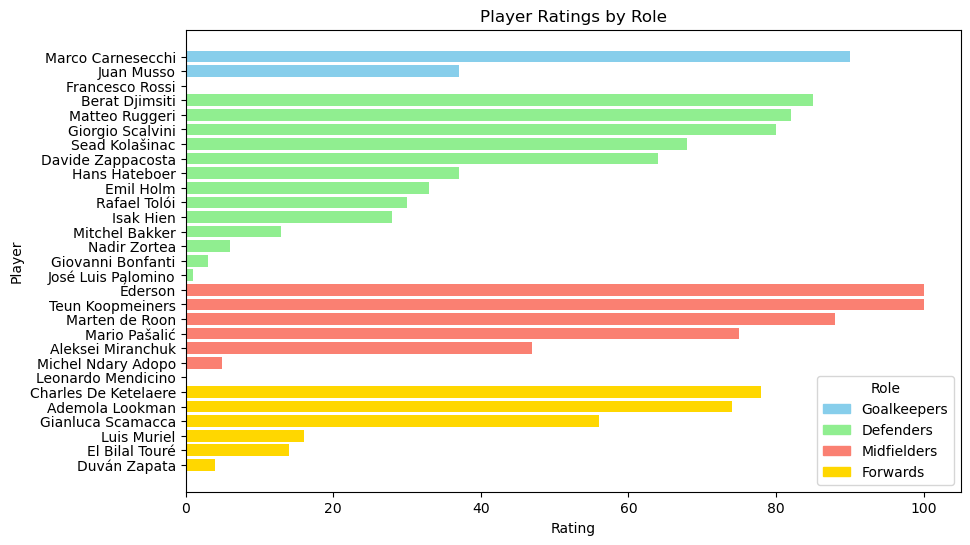

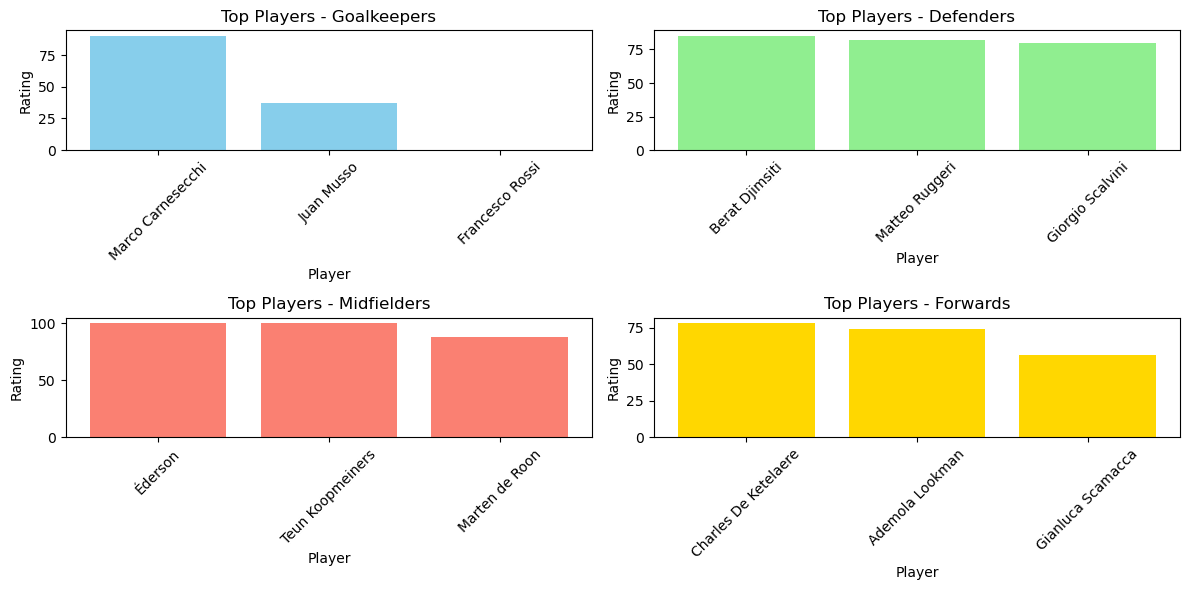

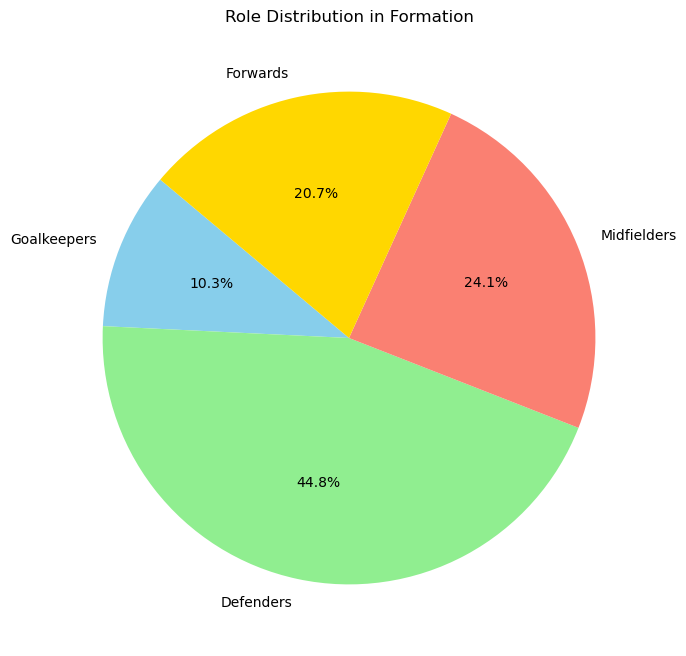

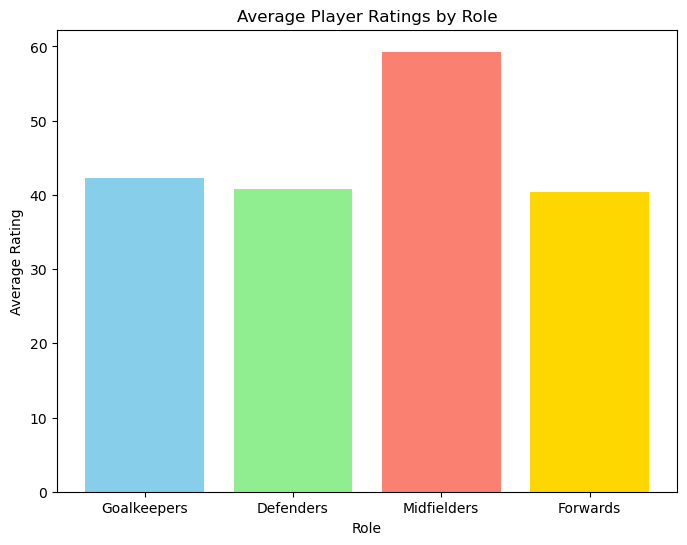

In [186]:
import matplotlib.pyplot as plt

def plot_player_ratings(players):
    roles_colors = {"Goalkeepers": 'skyblue', "Defenders": 'lightgreen', "Midfielders": 'salmon', "Forwards": 'gold'}
    
    # Ordina i giocatori prima per ruolo e poi per rating all'interno di ciascun ruolo
    players.sort(key=lambda x: (roles_order.index(x[2]), x[1]), reverse=True)
    
    names = [player[0] for player in players]
    ratings = [player[1] for player in players]
    roles = [player[2] for player in players]
    colors = [roles_colors[role] for role in roles]
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(names, ratings, color=colors)
    plt.xlabel('Rating')
    plt.ylabel('Player')
    plt.title('Player Ratings by Role')
    plt.gca().invert_yaxis()
    
    # Aggiunta legenda per i colori dei ruoli
    legend_handles = [plt.Rectangle((0,0),1,1, color=roles_colors[role]) for role in roles_colors.keys()]
    plt.legend(legend_handles, roles_colors.keys(), title="Role")
    
    plt.show()

roles_order = ["Forwards", "Midfielders", "Defenders", "Goalkeepers"]


# Call the function to generate the plot
players = [(player[0], player[1], role) for role in best_players for player in best_players[role]]
plot_player_ratings(players)

# Pie chart for role distribution
def plot_role_distribution(players):
    roles = ["Goalkeepers", "Defenders", "Midfielders", "Forwards"]
    counts = [len(players[role]) for role in roles]
    colors = [roles_colors[role] for role in roles]
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=roles, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title('Role Distribution in Formation')
    plt.savefig(f'Exports/Reports/Formation/{team}/{team} - Role Distribution.png')
    plt.show()

# Bar chart for average player ratings by role
def plot_average_ratings_by_role(players):
    roles = ["Goalkeepers", "Defenders", "Midfielders", "Forwards"]
    average_ratings = [sum(player[1] for player in players[role]) / len(players[role]) for role in roles]
    colors = [roles_colors[role] for role in roles]
    plt.figure(figsize=(8, 6))
    plt.bar(roles, average_ratings, color=colors)
    plt.xlabel('Role')
    plt.ylabel('Average Rating')
    plt.title('Average Player Ratings by Role')
    plt.savefig(f'Exports/Reports/Formation/{team}/{team} - Average Evaluation.png')
    plt.show()
    
# Bar chart to show ratings of top players by role
def plot_top_players_by_role(players):
    roles = ["Goalkeepers", "Defenders", "Midfielders", "Forwards"]
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    for i, role in enumerate(roles):
        players_sorted = sorted(players[role], key=lambda x: x[1], reverse=True)[:3]  # Show top 3 players per role
        names = [player[0] for player in players_sorted]
        ratings = [player[1] for player in players_sorted]
        ax = axs[i // 2, i % 2]  # Calculate subplot position
        ax.bar(names, ratings, color=[roles_colors[role]] * len(names))  # Repeat role color for each player
        ax.set_xlabel('Player')
        ax.set_ylabel('Rating')
        ax.set_title(f'Top Players - {role}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(f'Exports/Reports/Formation/{team}/{team} - Top Players by Role.png')
    plt.show()

# Call functions to generate plots
plot_top_players_by_role(best_players)
plot_role_distribution(best_players)
plot_average_ratings_by_role(best_players)